In [1]:
import os
import gc
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    path = '../../../datasets/garanti-bbva-data-camp/'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [2]:
train_df = pd.read_csv(os.path.join(config.path, 'train_users.csv'))
test_df = pd.read_csv(os.path.join(config.path, 'test_users.csv'))
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')

train_df shape: (53019, 4)
test_df shape: (13255, 3)


In [3]:
df = train_df.append(test_df)

df.head()

,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [4]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)

    return df_

In [5]:
df = fix_location(df)

skills_df = load_skills(config.skills_path, 30)
lang_df = load_languages(config.languages_path)
edu_df = load_education(config.education_path, 12)
#exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
#df = df.merge(exp_df, on = ['user_id'], how = 'left')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 318624


100%|██████████| 12/12 [00:02<00:00,  4.26it/s]

(66274, 59)


,user_id,industry,location,moved_after_2019,skill_Java,skill_JavaScript,skill_SQL,skill_C#,skill_Software Development,skill_HTML,...,study_Computer Programming,study_Computer Science,"study_Business Administration and Management, General",study_Mechanical Engineering,study_Software Engineering,study_Management Information Systems,study_Industrial Engineering,study_Mathematics,study_İşletme,study_Elektronik ve Haberleşme Mühendisliği
0,1301,Information Technology and Services,ISTANBUL,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,6950,Internet,ISTANBUL,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4880,Online Media,TURKEY,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26046,Telecommunications,ISTANBUL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11005,Banking,ISTANBUL,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
target = 'moved_after_2019'
cat_features = ['industry', 'location']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 58)
test_set: (13255, 58)


In [7]:
params = {'subsample': 0.8,
          'bootstrap_type':'Bernoulli',
          'depth': 9,
          'one_hot_max_size': 150}

params['verbose'] = False
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params["iterations"] = 5000

kf = KFold(n_splits=config.n_folds)


In [8]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6177403	test: 0.6181962	best: 0.6181962 (0)	total: 70.6ms	remaining: 5m 52s
200:	learn: 0.7159250	test: 0.6637999	best: 0.6645921 (180)	total: 2.65s	remaining: 1m 3s
400:	learn: 0.7491512	test: 0.6802082	best: 0.6802082 (400)	total: 5.17s	remaining: 59.4s
600:	learn: 0.7719660	test: 0.6847346	best: 0.6862057 (572)	total: 7.68s	remaining: 56.2s
800:	learn: 0.7891449	test: 0.6910716	best: 0.6917506 (797)	total: 10.2s	remaining: 53.4s
1000:	learn: 0.8039699	test: 0.6965033	best: 0.6969560 (995)	total: 12.9s	remaining: 51.7s
1200:	learn: 0.8161468	test: 0.7009166	best: 0.7014824 (1185)	total: 15.4s	remaining: 48.8s
1400:	learn: 0.8281200	test: 0.7015956	best: 0.7031798 (1267)	total: 17.9s	remaining: 46s
1600:	learn: 0.8371282	test: 0.7055562	best: 0.7071404 (1538)	total: 20.4s	remaining: 43.4s
1800:	learn: 0.8458648	test: 0.7087247	best: 0.7089510 (1794)	total: 22.8s	r

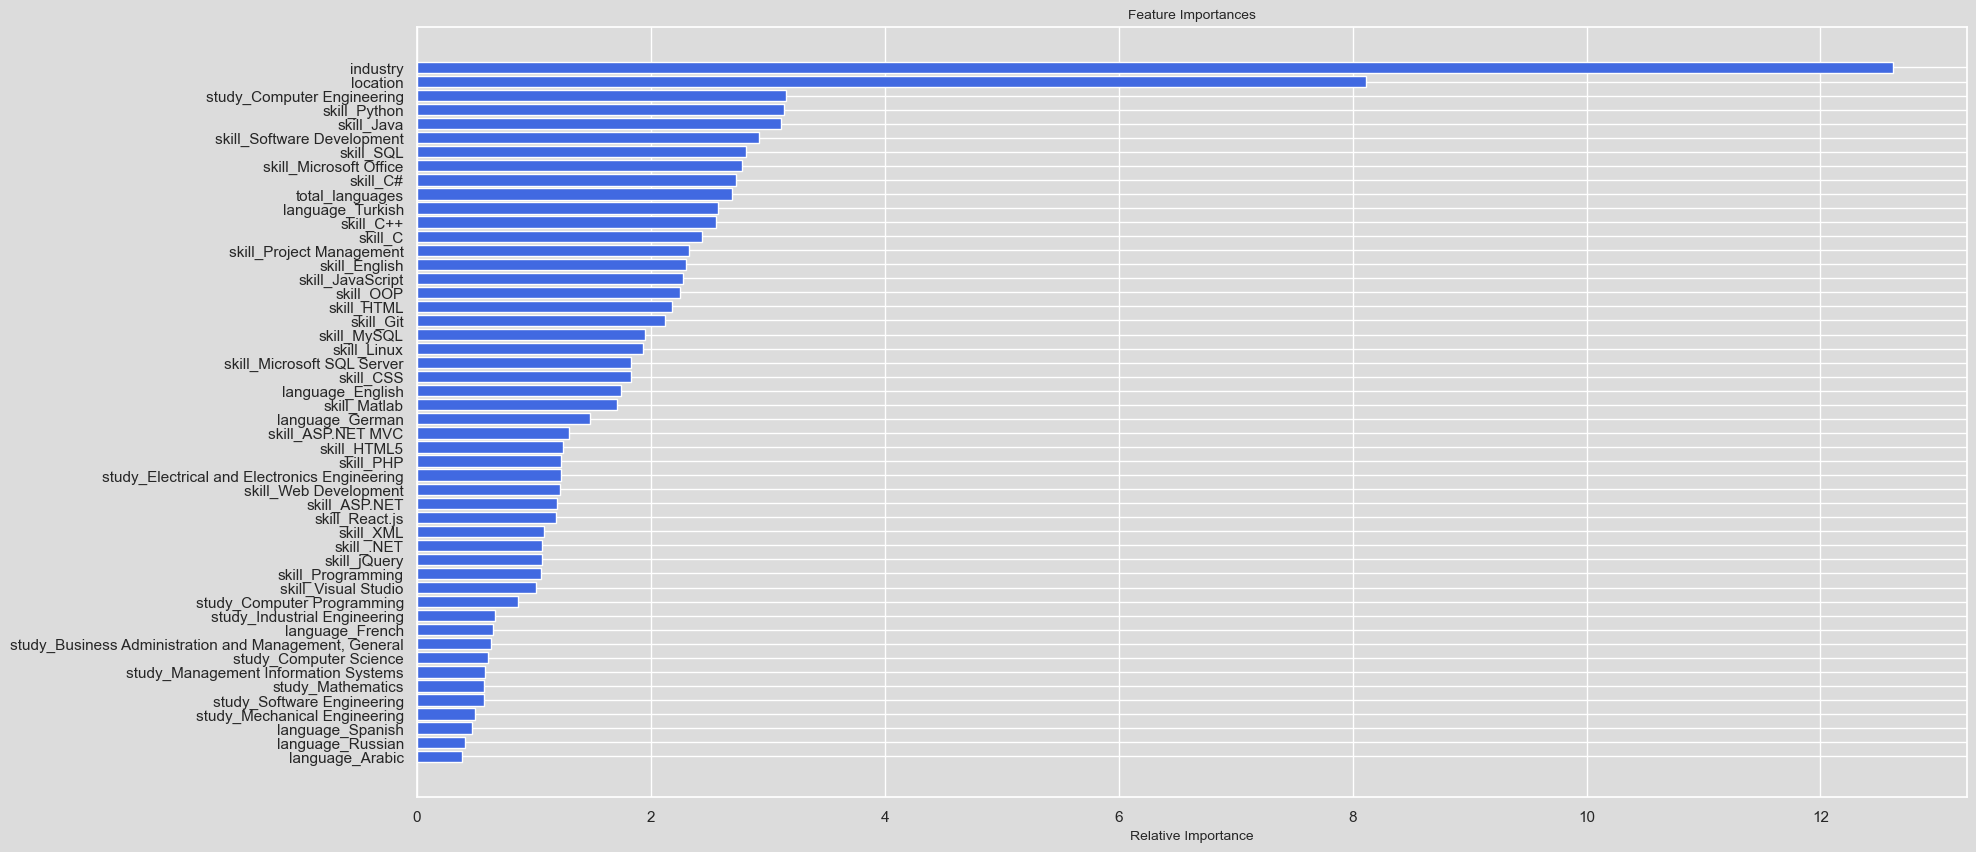

accuracy: 0.727735656897137
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6174234	test: 0.6195541	best: 0.6195541 (0)	total: 7.26ms	remaining: 36.3s
200:	learn: 0.7139785	test: 0.6630078	best: 0.6630078 (199)	total: 2.44s	remaining: 58.4s
400:	learn: 0.7448282	test: 0.6752292	best: 0.6757950 (369)	total: 4.83s	remaining: 55.4s
600:	learn: 0.7698158	test: 0.6859794	best: 0.6863189 (588)	total: 7.23s	remaining: 52.9s
800:	learn: 0.7861799	test: 0.6899400	best: 0.6899400 (800)	total: 9.65s	remaining: 50.6s
1000:	learn: 0.8003938	test: 0.6915243	best: 0.6934480 (948)	total: 12s	remaining: 48s
1200:	learn: 0.8142004	test: 0.6955981	best: 0.6972955 (1153)	total: 14.4s	remaining: 45.5s
1400:	learn: 0.8250871	test: 0.7005771	best: 0.7010298 (1374)	total: 16.8s	remaining: 43s
1600:	learn: 0.8357023	test: 0.7037456	best: 0.7038588 (1567)	total: 19.2s	remaining: 40.7s
1800:	learn: 0.8438957	test: 0.7084984	best: 0.708724

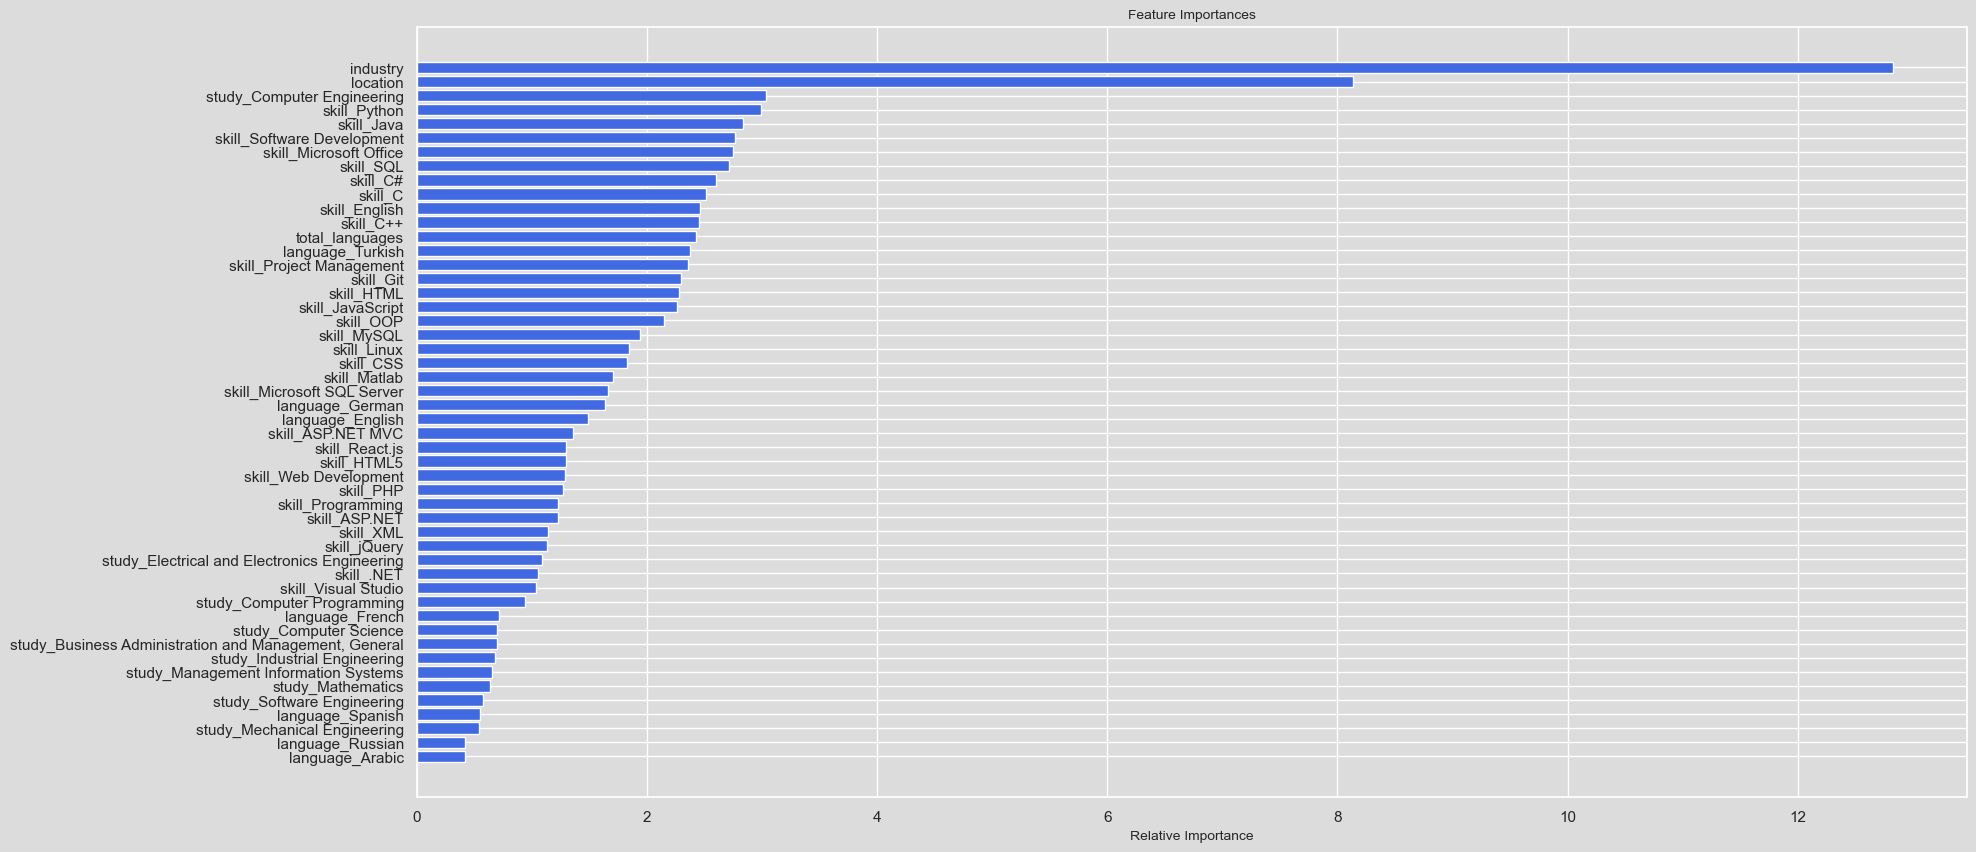

accuracy: 0.7216249858549282
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6179213	test: 0.6170646	best: 0.6170646 (0)	total: 9.12ms	remaining: 45.6s
200:	learn: 0.7155629	test: 0.6636868	best: 0.6636868 (200)	total: 2.4s	remaining: 57.4s
400:	learn: 0.7474763	test: 0.6757950	best: 0.6762476 (385)	total: 4.72s	remaining: 54.2s
600:	learn: 0.7715586	test: 0.6849610	best: 0.6864320 (585)	total: 7.08s	remaining: 51.8s
800:	learn: 0.7915667	test: 0.6940138	best: 0.6942401 (776)	total: 9.48s	remaining: 49.7s
1000:	learn: 0.8049432	test: 0.6986534	best: 0.6991060 (949)	total: 11.8s	remaining: 47.3s
1200:	learn: 0.8161242	test: 0.7012561	best: 0.7019350 (1187)	total: 14.2s	remaining: 44.9s
1400:	learn: 0.8264678	test: 0.7055562	best: 0.7057825 (1398)	total: 16.5s	remaining: 42.4s
1600:	learn: 0.8361550	test: 0.7104221	best: 0.7108747 (1578)	total: 18.9s	remaining: 40s
1800:	learn: 0.8455480	test: 0.7103089	best: 0.71

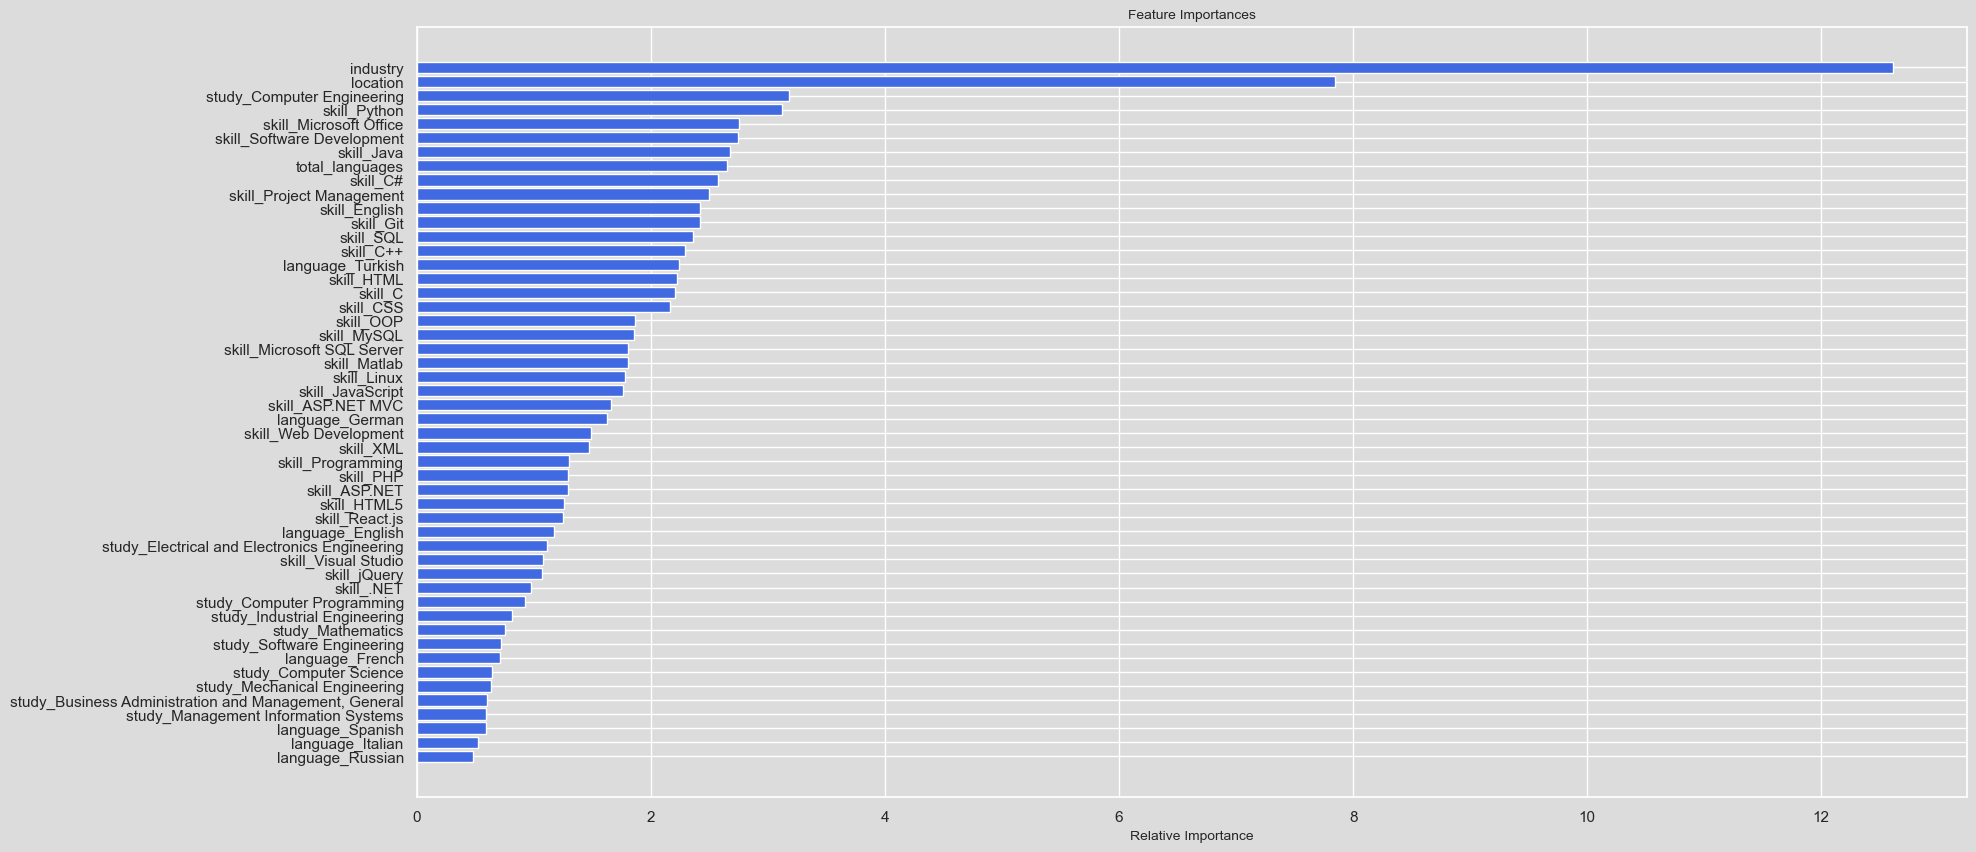

accuracy: 0.7129116215910377
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6177036	test: 0.6183794	best: 0.6183794 (0)	total: 10.1ms	remaining: 50.7s
200:	learn: 0.7161125	test: 0.6627433	best: 0.6630828 (197)	total: 2.56s	remaining: 1m 1s
400:	learn: 0.7516692	test: 0.6775690	best: 0.6784744 (394)	total: 5.02s	remaining: 57.5s
600:	learn: 0.7753887	test: 0.6841331	best: 0.6843594 (595)	total: 7.46s	remaining: 54.6s
800:	learn: 0.7904398	test: 0.6902445	best: 0.6912630 (792)	total: 9.9s	remaining: 51.9s
1000:	learn: 0.8057398	test: 0.6948846	best: 0.6955636 (990)	total: 12.3s	remaining: 49.1s
1200:	learn: 0.8174185	test: 0.6996378	best: 0.7009959 (1194)	total: 14.7s	remaining: 46.4s
1400:	learn: 0.8298214	test: 0.7025804	best: 0.7029199 (1375)	total: 17.1s	remaining: 43.9s
1600:	learn: 0.8400290	test: 0.7065414	best: 0.7074468 (1564)	total: 19.5s	remaining: 41.3s
1800:	learn: 0.8477921	test: 0.7071073	best: 0.

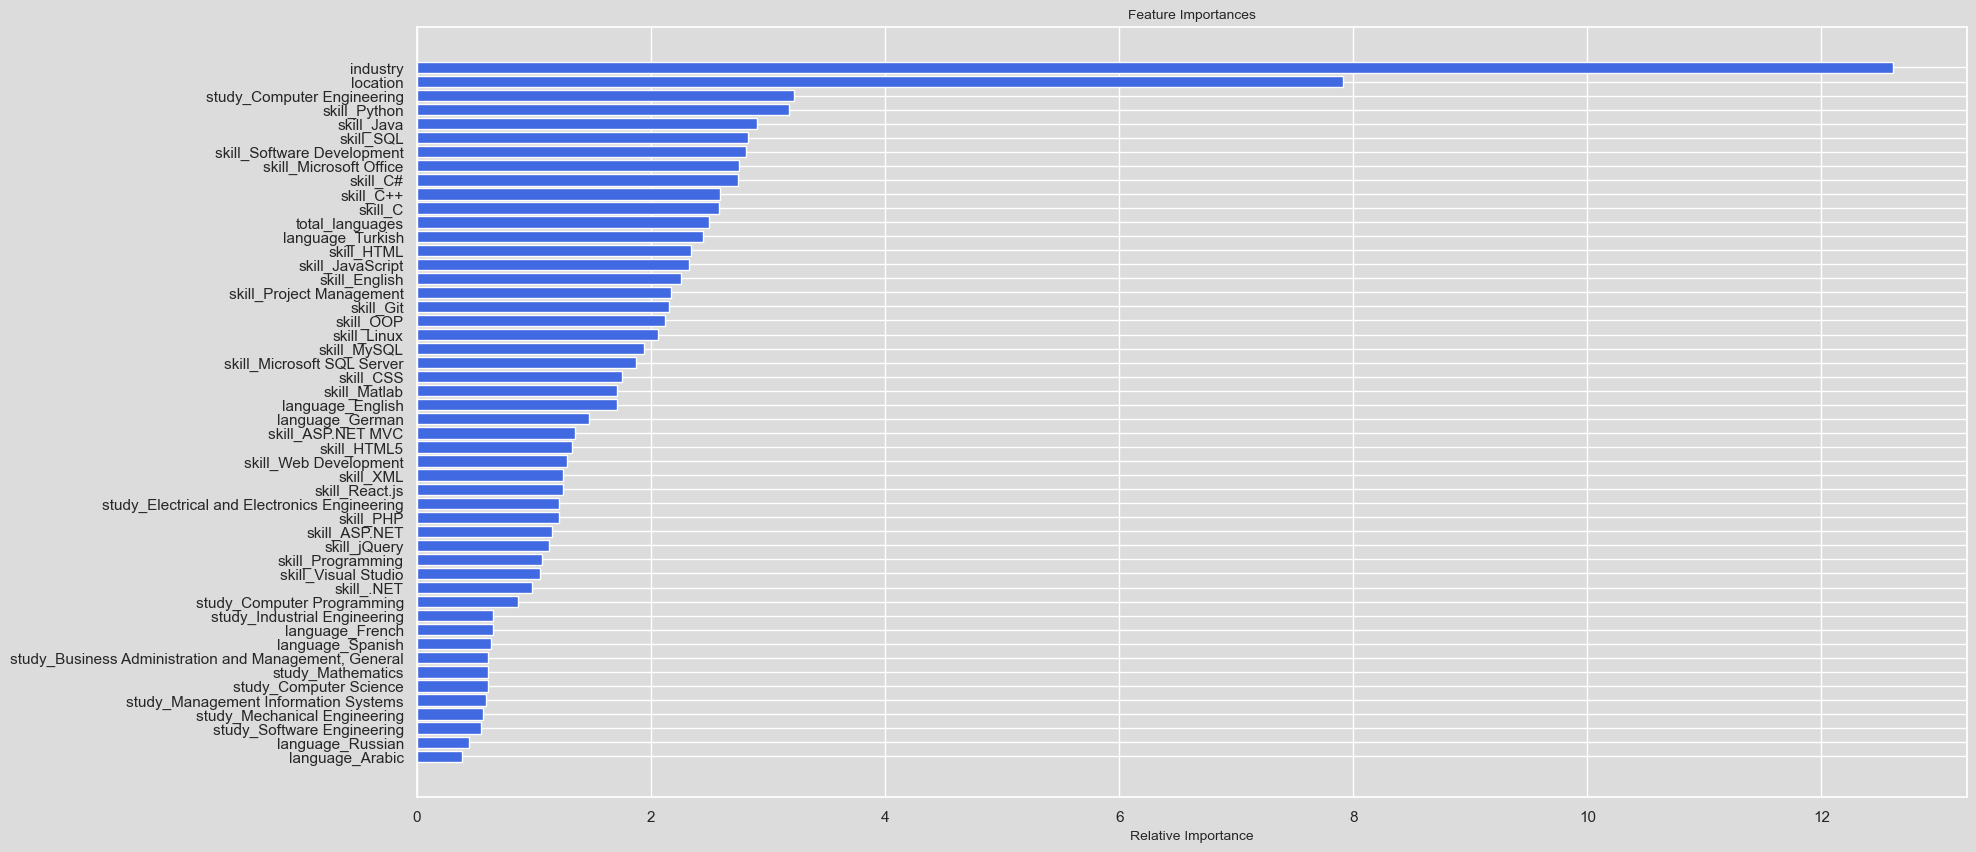

accuracy: 0.7223856948845632
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6274812	test: 0.6221141	best: 0.6221141 (0)	total: 16.3ms	remaining: 1m 21s
200:	learn: 0.7180816	test: 0.6668176	best: 0.6677230 (194)	total: 3.04s	remaining: 1m 12s
400:	learn: 0.7487722	test: 0.6830014	best: 0.6832277 (399)	total: 6.02s	remaining: 1m 9s
600:	learn: 0.7702057	test: 0.6920552	best: 0.6920552 (599)	total: 8.97s	remaining: 1m 5s
800:	learn: 0.7876559	test: 0.6999774	best: 0.6999774 (796)	total: 11.9s	remaining: 1m 2s
1000:	learn: 0.8039517	test: 0.7057492	best: 0.7066546 (995)	total: 15.1s	remaining: 1m
1200:	learn: 0.8165810	test: 0.7077863	best: 0.7083522 (1102)	total: 18.2s	remaining: 57.6s
1400:	learn: 0.8289614	test: 0.7123133	best: 0.7134450 (1381)	total: 21.3s	remaining: 54.6s
1600:	learn: 0.8391689	test: 0.7157085	best: 0.7163875 (1563)	total: 24.3s	remaining: 51.5s
1800:	learn: 0.8479732	test: 0.7171797	best: 0.

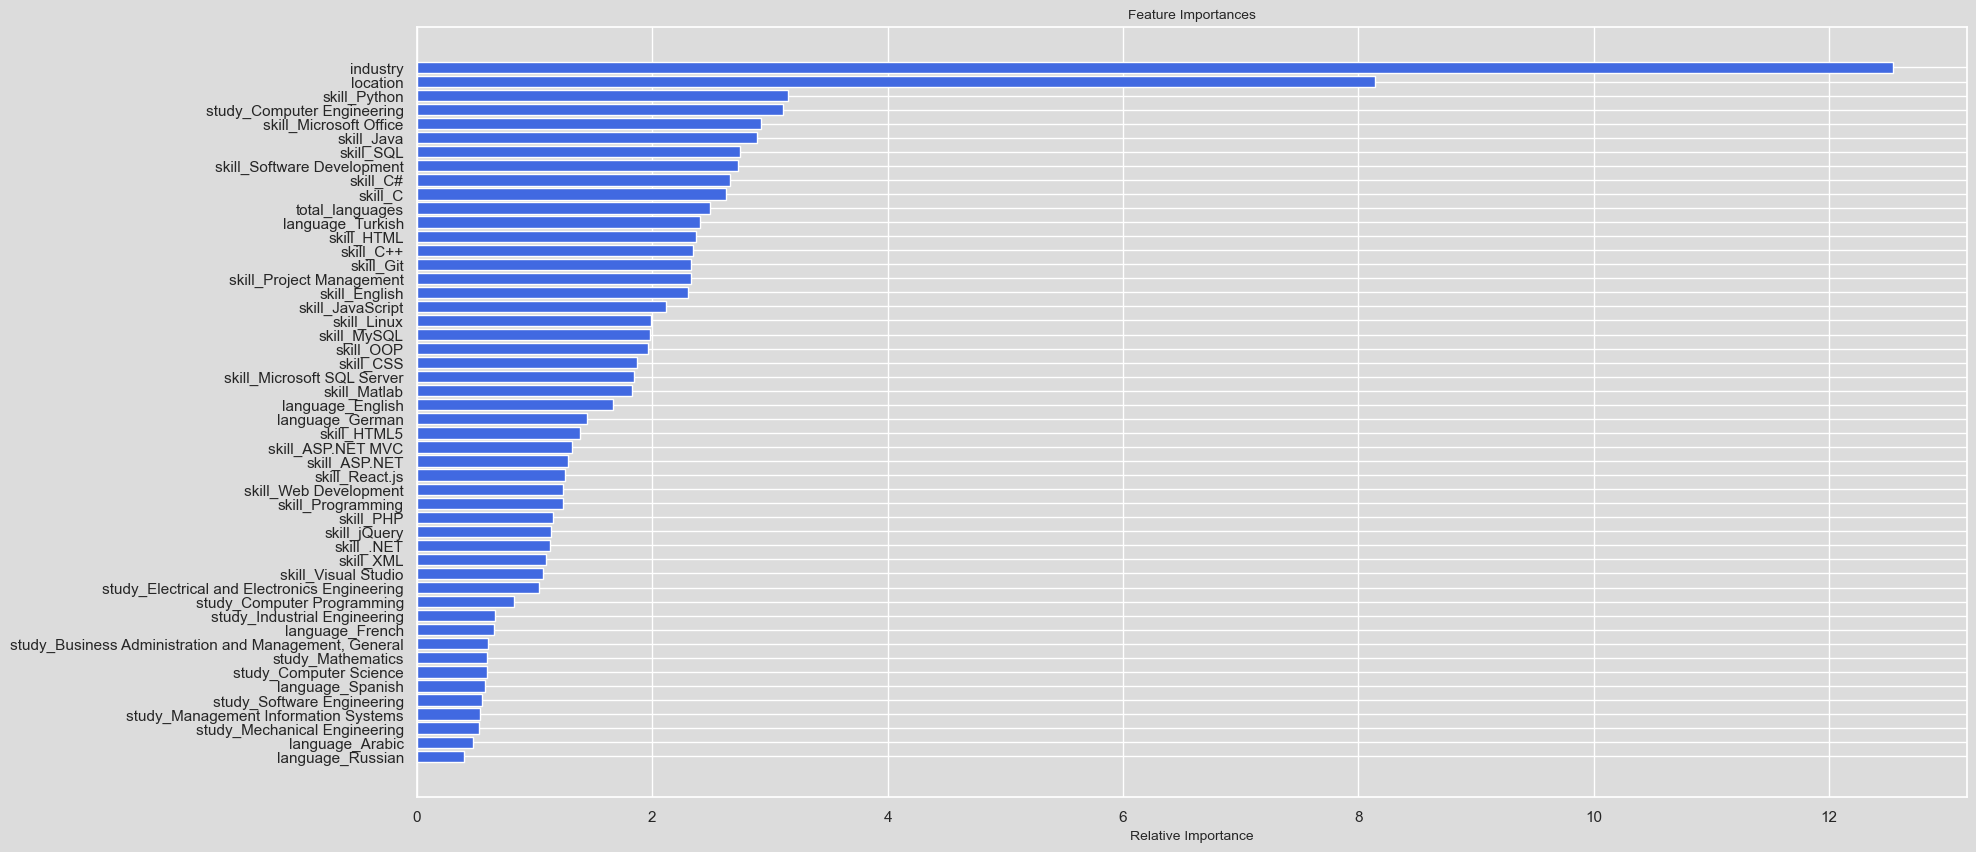

accuracy: 0.7281575373472159
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6188579	test: 0.6126075	best: 0.6126075 (0)	total: 7.87ms	remaining: 39.3s
200:	learn: 0.7150488	test: 0.6599140	best: 0.6603667 (197)	total: 2.45s	remaining: 58.5s
400:	learn: 0.7511260	test: 0.6714577	best: 0.6723631 (374)	total: 4.88s	remaining: 55.9s
600:	learn: 0.7728085	test: 0.6800589	best: 0.6810774 (597)	total: 7.26s	remaining: 53.1s
800:	learn: 0.7916620	test: 0.6876415	best: 0.6882073 (797)	total: 9.66s	remaining: 50.6s
1000:	learn: 0.8063509	test: 0.6940923	best: 0.6944319 (998)	total: 12s	remaining: 48.1s
1200:	learn: 0.8179164	test: 0.6955636	best: 0.6965822 (1196)	total: 14.5s	remaining: 45.8s
1400:	learn: 0.8291877	test: 0.7003169	best: 0.7006564 (1378)	total: 17s	remaining: 43.6s
1600:	learn: 0.8397347	test: 0.7026935	best: 0.7042780 (1495)	total: 19.6s	remaining: 41.7s
1800:	learn: 0.8488785	test: 0.7050702	best: 0.705

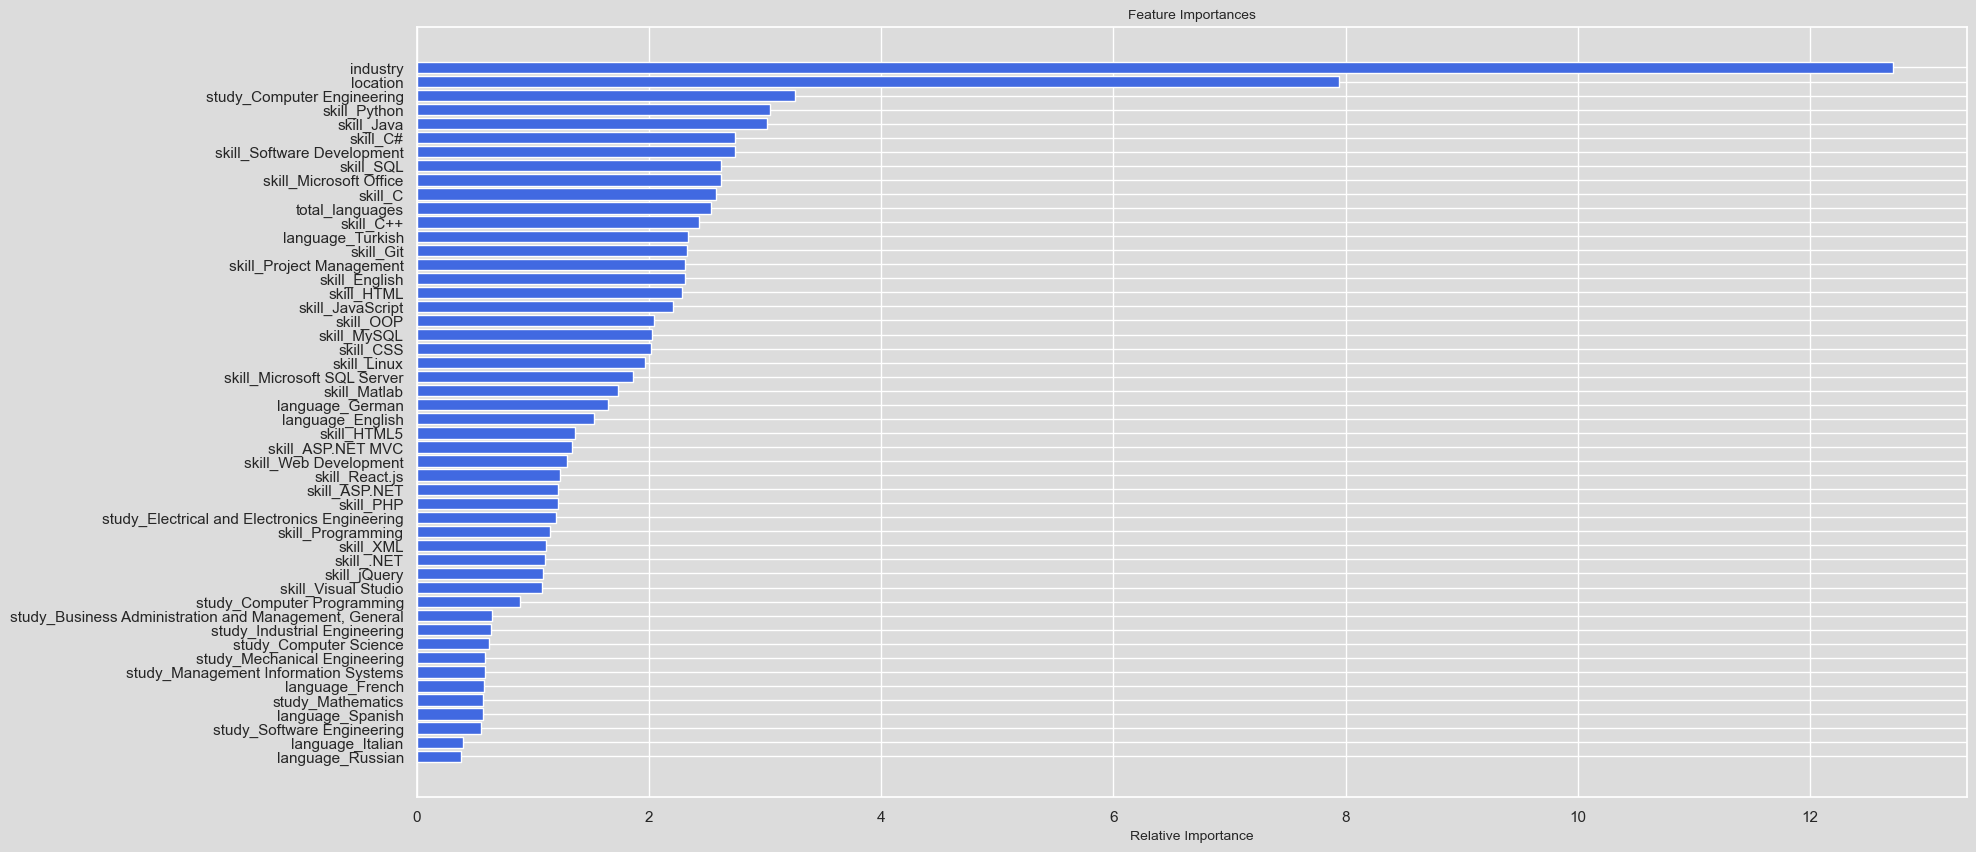

accuracy: 0.7206880941602535


In [9]:
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()


In [10]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,0
2,2110,0
3,55082,0
4,37165,0


In [11]:
sub.to_csv(f'../submissions/submission_{round(0.7206880941602535, 6)}.csv', index = False)